In [1]:
# https://arxiv.org/abs/cond-mat/0703314
# https://arxiv.org/abs/0808.3779

# https://github.com/scipy/scipy/issues/7151
# https://apps.dtic.mil/sti/pdfs/AD1004183.pdf
# https://www.codeproject.com/Articles/21282/Compute-Permanent-of-a-Matrix-with-Ryser-s-Algorit

# https://rosettacode.org/wiki/Determinant_and_permanent
# https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible

# https://stackoverflow.com/questions/38738835/generating-gray-codes
# https://qiita.com/b1ueskydragon/items/75cfee42541ea723080c

# https://qiita.com/phdax/items/3064de264c7933bab2f5
# https://web.archive.org/web/20190108235115/https://www.hackersdelight.org/hdcodetxt/pop.c.txt
# http://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetParallel
# https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer

# https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time

In [3]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
@jit(nopython=True)
def calc_rsks(L):
    rs = np.arange(1,L+1) ## from 1 to L
    ks = np.linspace(np.pi/(L+1.0),L*np.pi/(L+1.0),L)
    return rs,ks

@jit(nopython=True)
def calc_eks(J,ks):
    return -2.0*J*np.cos(ks)

@jit(nopython=True)
def calc_xkrs(L,ks,rs):
    return np.sqrt(2.0/(L+1.0))*np.sin(np.outer(ks,rs))

@jit(nopython=True)
def calc_ys(t,eks,xkrs):
    xc = (1.0+0.0j)*xkrs # for numba
    expeks = np.diag(np.exp(1j*t*eks))
    return xc @ expeks @ xc

# @jit(nopython=True)
# def calc_fs(ys,system):
#     diag = (1.0+0.0j)*np.diag(system)
#     return ys @ diag @ ys.T.conjugate()

@jit(nopython=True)
def calc_fs_cdw(ys,system,period=1):
    diag = (1.0+0.0j)*np.diag(system)
    ycuts = np.copy(ys[::period,:]) ## avoid NumbaPerformanceWarning to make contiguous arrays by deep copy
#    ycuts = ys[::period,:]
    return ycuts @ diag @ ycuts.T.conjugate()

@jit(nopython=True)
def calc_z(L,system,t,eks,xkrs,period=1):
    ys = calc_ys(t,eks,xkrs)
#    fs = calc_fs(ys,system)
    fs = calc_fs_cdw(ys,system,period)
    dlt = np.eye(fs.shape[0],dtype=np.complex128)
    return np.vstack( (np.hstack((fs,dlt-fs)), np.hstack((dlt-fs,fs))) )

@jit(nopython=True)
def get_dat(L,system,J,ts,period=1):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    data = np.zeros((len(ts),2),dtype=np.float64)
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period)
        data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
    return data

In [5]:
period = 1
J = 1.0
#Ls = [4,6,8,10]
L = 10
#ts = np.linspace(0,20,201)
ts = np.linspace(0,10*L,int(L/0.1)+1)

rs, ks = calc_rsks(L)
eks = calc_eks(J,ks)
xkrs = calc_xkrs(L,ks,rs)
system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])

#t = 0.1*L
t = 2.0*L
matz = calc_z(L,system,t,eks,xkrs,period)
#print(matz)

#matz = np.eye(2*L)

perm = perm_bbfg(matz).real
print(perm)
ee2 = np.array([t,-np.log(perm)])
print(ee2)

0.004790164988348742
[20.          5.34119042]


In [6]:
#print(matz)

In [7]:
seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10
lenmatz = matz.shape[0]
#print(lenmatz)

bounds = []
for step in range(Nsmp):
#    vec = rng.uniform(-1,1,lenmatz) + 1j * rng.uniform(-1,1,lenmatz)
#    vec = vec/np.linalg.norm(vec)
    rnd = np.pi * rng.uniform(-1,1,lenmatz)
    vec = np.cos(rnd) + 1j * np.sin(rnd)
#    print(np.linalg.norm(vec))
#    bound = (np.linalg.norm(matz.dot(vec),ord=1)/lenmatz)**lenmatz
#    bound = (np.sum(np.abs(matz.dot(vec)))/lenmatz)**lenmatz
    bound = np.prod(np.abs(matz.dot(vec)))
    bounds.append(bound)
bounds = np.array(bounds)

In [8]:
ave = np.average(bounds)
err = np.std(bounds,ddof=1)/np.sqrt(len(bounds))
print(bounds)
print(ave)
print(err)
print(-np.log(ave))

[0.00315944 0.00059363 0.05101767 ... 0.00094213 0.00193306 0.00022739]
0.01958729473918007
0.0011332762176142865
3.932874150528864


In [9]:
@jit(nopython=True)
def get_dat_2(L,system,J,ts,Nsmp,rnd,period=1):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    data = np.zeros((len(ts),2),dtype=np.float64)
    #
    #seed = 12345
    #rng = np.random.default_rng(seed)
    #Nsmp = 2**10
    data2 = np.zeros((len(ts),2),dtype=np.float64)
    #
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period)
        #data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
        #
        lenmatz = matz.shape[0]
        bounds = np.zeros(Nsmp,dtype=np.float64)
        for step in range(Nsmp):
            #rnd = np.pi * rng.uniform(-1,1,lenmatz)
            vec = np.cos(rnd[step]) + 1j * np.sin(rnd[step])
            #bounds[step] = (np.sum(np.abs(matz.dot(vec)))/lenmatz)**lenmatz
            bounds[step] = np.prod(np.abs(matz.dot(vec)))
        #data2[i] = np.array([t,-np.log(np.average(bounds))])
        data2[i] = np.array([t,-np.log(np.sum(bounds)/len(bounds))])
        #
    return data, data2

L,calctime: 4 2.9127438068389893
L,calctime: 6 0.2525179386138916
L,calctime: 8 0.3433549404144287
L,calctime: 10 0.4074289798736572
L,calctime: 12 0.4611330032348633
L,calctime: 14 0.5252060890197754
L,calctime: 16 0.6569507122039795
L,calctime: 18 0.7025821208953857
L,calctime: 20 0.7735028266906738
L,calctime: 22 0.7875618934631348
L,calctime: 24 0.8893351554870605
L,calctime: 26 0.9692811965942383
L,calctime: 28 1.1028962135314941
L,calctime: 30 1.1849620342254639
L,calctime: 32 1.3882989883422852
L,calctime: 34 1.421478033065796
L,calctime: 36 1.5900530815124512
L,calctime: 38 1.7259888648986816
L,calctime: 40 1.8197498321533203


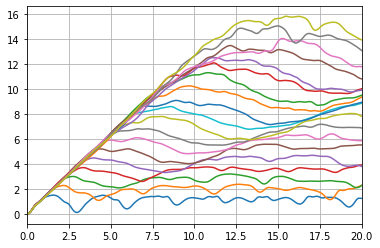

In [10]:
## Mott insulator initial

period = 1
J = 1.0
ts = np.linspace(0,20,201)
#Ls = [4,6,8,10]
Ls = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    #
    rnd = np.zeros((Nsmp,2*L),dtype=np.float64)
    for step in range(Nsmp):
        rnd[step] = np.pi * rng.uniform(-1,1,2*L)
    #
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
#    datas[i] = get_dat(L,system,J,ts,period)
    datas[i], datas2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
plt.xlim(0,20)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas2[i,:,0],datas2[i,:,1])
plt.show()

L,calctime: 4 0.2685878276824951
L,calctime: 6 0.2797579765319824
L,calctime: 8 0.2868080139160156
L,calctime: 10 0.2777981758117676
L,calctime: 12 0.29488325119018555
L,calctime: 14 0.34111499786376953
L,calctime: 16 0.34052205085754395
L,calctime: 18 0.39025306701660156
L,calctime: 20 0.42084503173828125
L,calctime: 22 0.4649207592010498
L,calctime: 24 0.483518123626709
L,calctime: 26 0.5243849754333496
L,calctime: 28 0.5233609676361084
L,calctime: 30 0.5393731594085693
L,calctime: 32 0.6507461071014404
L,calctime: 34 0.7029299736022949
L,calctime: 36 0.6925680637359619
L,calctime: 38 0.717249870300293
L,calctime: 40 0.7776119709014893


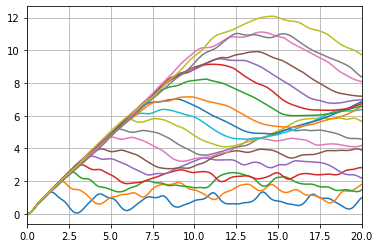

In [11]:
## CDW 010101... initial

period = 2
J = 1.0
ts = np.linspace(0,20,201)
#Ls = [4,6,8,10,12,14,16,18,20]
Ls = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    #
    rnd = np.zeros((Nsmp,L),dtype=np.float64)
    for step in range(Nsmp):
        rnd[step] = np.pi * rng.uniform(-1,1,L)
    #
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
#    datas[i] = get_dat(L,system,J,ts,period)
    datas[i], datas2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
plt.xlim(0,20)
plt.grid()
for i,L in enumerate(Ls):
    plt.plot(datas2[i,:,0],datas2[i,:,1])
plt.show()